In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import string
import math
!pip install pycocotools
!pip install torchinfo
from pycocotools.coco import COCO
import json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 576.6 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370080 sha256=a2eb594ffa49e10799ee254592d050611f651dae173dcaecdd81815986a308ee
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


In [2]:
folder1 = '../input/mscoco-cv/MSCOCO/MSCOCO'
folder2 = '../input/coco2014/captions'

In [3]:
test_info = json.loads(open(os.path.join(folder1,'annotations','image_info_test2014.json')).read())
test_info.keys()

dict_keys(['info', 'images', 'licenses', 'categories'])

In [4]:
dataType = 'val2014'
instances_file = os.path.join(folder2, 'annotations','captions_{}.json'.format(dataType))
coco= COCO(instances_file)

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


In [5]:
coco.__dict__.keys()

dict_keys(['dataset', 'anns', 'cats', 'imgs', 'imgToAnns', 'catToImgs'])

In [6]:
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

COCO_val2014_000000493724.jpg


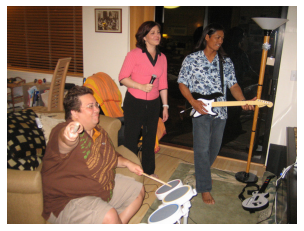

Three ladies using music instruments in a living room.
A group of ladies enjoying a video game.
Two women are singing and playing karaoke together. 
Three women playing Wii rock band in a living room.
A group of adults playing rock band with each other. 


In [7]:
ids = list(coco.anns.keys())
key_id = np.random.choice(ids)
img_id = coco.anns[key_id]['image_id']
img_file = coco.loadImgs(img_id)[0]['file_name']

# print URL and visualize corresponding image
print(img_file)
I = io.imread(os.path.join('../input/coco2014', 'val2014', 'val2014', img_file))
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco.getAnnIds(imgIds=coco.loadImgs(img_id)[0]['id']);
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [8]:
print('Shape of image is {}'.format(I.shape))

Shape of image is (480, 640, 3)


In [9]:
import nltk
import pickle
import json
from collections import Counter



In [10]:
class Vocabulary(object):
    def __init__(self, vocab_threshold, captions_file,
                 start_word='<start>', end_word='<end>', unk_word='<unk>'):
        self.vocab_threshold = vocab_threshold
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = captions_file
        self.build_vocab()
    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, d in enumerate(ids):
            caption = str(coco.anns[d]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]
    def __len__(self):
        return len(self.word2idx)    

In [11]:
import torch
import torch.utils.data as data
from tqdm import tqdm
import random
from PIL import Image

In [12]:
class CoCoDataset(data.Dataset):
    def __init__(self, transform, mode, batch_size, vocab_threshold, start_word, 
        end_word, unk_word, annotations_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        if self.mode!='test':
            self.vocab = Vocabulary(vocab_threshold, annotations_file, start_word,
            end_word, unk_word)
        self.img_folder = img_folder
        if self.mode == 'train' or self.mode == 'valid':
            # JSON file, where the annotations are stored
            self.coco = COCO(annotations_file) 
            # each annotatin contains multiple attributes, such as task e.g. segmentation,
            # image_id, bounding box and etc.
            # in order to load an image, for instance, 
            # image URL we will use self.coco.loadImgs(image_id) based on image id
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            # get all_tokens - a big list of lists. Each is a list of tokens for specific caption
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            # list of token lengths (number of words for each caption)
            self.caption_lengths = [len(token) for token in all_tokens]           
        else:
            # if we are in testing mode
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
    def process_caption(self, anns):
        tokens = nltk.tokenize.word_tokenize(str(anns).lower())
        caption = []
        caption.append(self.vocab(self.vocab.start_word))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab(self.vocab.end_word))
        caption = torch.Tensor(caption).long()
        return caption
    def __getitem__(self, index):
        if self.mode=='train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)
            caption = self.process_caption(caption)
            # return pre-processed image and caption tensors
            # image pre-processed with tranformer applied
            return image, caption
        elif self.mode=='valid':
            ann_id = self.ids[index]
            # Convert image to tensor and pre-process using transform           
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)
            caption = self.process_caption(caption)
            caps_all = []
            # based on image id, get id of all related annotations
            ids_ann = self.coco.getAnnIds(imgIds=img_id)
            for ann_id in ids_ann:
                capt = self.coco.anns[ann_id]['caption']
                caps_all.append(capt)            
            # return original image and pre-processed image tensor
            return image, caption, ['|'.join(caps_all)]
        else:
            path = self.paths[index]
            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            # return original image and pre-processed image tensor
            return orig_image, image
    def get_indices(self):
        # randomly select the caption length from the list of lengths
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        # select m = batch_size captions from list above
        # return the caption indices of specified batch
        return all_indices

    def __len__(self):
        if self.mode == 'train' or self.mode == 'valid':
            return len(self.ids)
        else:
            return len(self.paths)         
            
                
            

In [35]:
def get_loader(transform,
               mode='train',
               # default batch size
               batch_size=1,
               vocab_threshold=1,
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               num_workers=0):
    #path = os.getcwd()
    path = folder2
    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    img_path = '../input/coco2014'
    if mode == 'train':
        img_folder = os.path.join(img_path, 'train2014', 'train2014')
        annotations_file = os.path.join(path, 'annotations', 'captions_train2014.json')
        
    elif mode == 'valid':
        img_folder = os.path.join(img_path, 'val2014', 'val2014')
        annotations_file = os.path.join(path, 'annotations', 'captions_val2014.json')
        
    elif mode == 'test':
        img_folder = os.path.join(folder1, 'test2014')        
        annotations_file = os.path.join(folder1, 'annotations', 'image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          img_folder=img_folder)

    if mode == 'train' or mode == 'valid':
        # Randomly sample a caption length and indices of that length
        indices = dataset.get_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices
        # functionality from torch.utils
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    elif mode == 'test':
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

In [14]:
#vocab_threshold = 5


#batch_size = 10

# Obtain the data loader.
#data_loader = get_loader(transform=img_transform,
#                         mode='train',
#                         batch_size=batch_size,
#                         vocab_threshold=vocab_threshold)

In [15]:
#print('The shape of first image:', data_loader.dataset[0][0].shape)

In [16]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class EncoderCNN(nn.Module):
    """Encoder inputs images and returns feature maps"""
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)
        # first, we need to resize the tensor to be
        # (batch, size*size, feature_maps)
        batch, feature_maps, size_1, size_2 = features.size()
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)

        return features

In [17]:
class BahdanauAttention(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(BahdanauAttention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W = nn.Linear(self.num_features, self.hidden_dim)
        self.U = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.v = nn.Linear(self.hidden_dim, self.output_dim)
    def forward(self, features, decoder_hidden):
        decoder_hidden = decoder_hidden.unsqueeze(1)
        atten_1 = self.W(features)
        atten_2 = self.U(decoder_hidden)
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)
        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)
        return context, atten_weight
    
        

In [18]:
class DecoderRNN(nn.Module):
    """Attributes:
    - embedding_dim - specified size of embeddings;
    - hidden_dim - the size of RNN layer (number of hidden states)
    - vocab_size - size of vocabulary
    - p - dropout probability
    """
    def __init__(self, num_features, embedding_dim, hidden_dim, vocab_size, p=0.6):
        super(DecoderRNN, self).__init__()

        self.num_features = num_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # scale the inputs to softmax
        self.sample_temp = 0.5

        # embedding layer that turns words into a vector of a specified size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTM will have a single layer of size 512 (512 hidden units)
        # it will input concatinated context vector (produced by attention)
        # and corresponding hidden state of Decoder
        self.lstm = nn.LSTMCell(embedding_dim + num_features, hidden_dim)
        # produce the final output
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # add attention layer
        self.attention = BahdanauAttention(num_features, hidden_dim)
        # dropout layer
        self.drop = nn.Dropout(p=p)
        # add initialization fully-connected layers
        # initialize hidden state and cell memory using average feature vector
        # Source: https://arxiv.org/pdf/1502.03044.pdf
        self.init_h = nn.Linear(num_features, hidden_dim)
        self.init_c = nn.Linear(num_features, hidden_dim)

    def forward(self, captions, features, sample_prob = 0.0):
        """Arguments
        ----------
        - captions - image captions
        - features - features returned from Encoder
        - sample_prob - use it for scheduled sampling
        Returns
        ----------
        - outputs - output logits from t steps
        - atten_weights - weights from attention network
        """
        # create embeddings for captions of size (batch, sqe_len, embed_dim)
        embed = self.embeddings(captions)
        h, c = self.init_hidden(features)
        seq_len = captions.size(1)
        feature_size = features.size(1)
        batch_size = features.size(0)
        # these tensors will store the outputs from lstm cell and attention weights
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)

        # scheduled sampling for training
        # we do not use it at the first timestep (<start> word)
        # but later we check if the probability is bigger than random
        for t in range(seq_len):
            sample_prob = 0.0 if t == 0 else 0.5
            use_sampling = np.random.random() < sample_prob
            if use_sampling == False:
                word_embed = embed[:,t,:]
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + hidden_dim)
            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            if use_sampling == True:
                # use sampling temperature to amplify the values before applying softmax
                scaled_output = output / self.sample_temp
                scoring = F.log_softmax(scaled_output, dim=1)
                top_idx = scoring.topk(1)[1]
                word_embed = self.embeddings(top_idx).squeeze(1)
            outputs[:, t, :] = output
            atten_weights[:, t, :] = atten_weight
        return outputs, atten_weights

    def init_hidden(self, features):

        """Initializes hidden state and cell memory using average feature vector.
        Arguments:
        ----------
        - features - features returned from Encoder
        Retruns:
        ----------
        - h0 - initial hidden state (short-term memory)
        - c0 - initial cell state (long-term memory)
        """
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0


    def greedy_search(self, features, max_sentence = 20):

        """Greedy search to sample top candidate from distribution.
        Arguments
        ----------
        - features - features returned from Encoder
        - max_sentence - max number of token per caption (default=20)
        Returns:
        ----------
        - sentence - list of tokens
        """

        sentence = []
        weights = []
        input_word = torch.tensor(0).unsqueeze(0).to(device)
        h, c = self.init_hidden(features)
        while True:
            embedded_word = self.embeddings(input_word)
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + context size)
            input_concat = torch.cat([embedded_word, context],  dim = 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            scoring = F.log_softmax(output, dim=1)
            top_idx = scoring[0].topk(1)[1]
            sentence.append(top_idx.item())
            weights.append(atten_weight)
            input_word = top_idx
            if (len(sentence) >= max_sentence or top_idx == 1):
                break
        return sentence, weights
    def beam_search(self, features, k=3, max_sequence=20):
        input_word = torch.tensor(0).unsqueeze(0).to(device)
        h, c = self.init_hidden(features)
        sentence, weights = [], []
        states = [(h,c)]*k
        candidates = [[0, [input_word]]]*k
        can_wts = [[]]*k
        for j in range(0,max_sequence):
            temp = []
            temp_states = []
            temp_wts = []
            for i, can in enumerate(candidates):
                input_word = can[-1][-1]
                if input_word[0].cpu().detach().item()!=1:
                    embedded_word = self.embeddings(input_word)
                    context, atten_weight = self.attention(features, states[i][0])
                    input_concat = torch.cat([embedded_word, context],  dim = 1)
                    h, c = self.lstm(input_concat, states[i])
                    h = self.drop(h)
                    output = self.fc(h)
                    scoring = F.log_softmax(output, dim=1)
                    v, idx = scoring[0].topk(k)
                    v, idx = list(v.cpu().detach().numpy()), list(idx.cpu().detach().numpy())
                    for value, index in zip(v, idx):
                        temp_wts.append(can_wts[i]+[atten_weight])
                        temp_states.append((h,c))
                        temp.append([value+can[0], can[-1]+[torch.tensor(index).unsqueeze(0).to(device)]])
                else:
                    temp.append(can)
                    temp_states.append(states[i])
                    temp_wts.append(can_wts[i])
            new_states, new_candidates, new_wts = [], [], []
            for count in range(0,k):
                curr = max(temp, key=lambda x:x[0]/(len(x[1]))**0.75)
                loc = temp.index(curr)
                new_candidates.append(curr)
                new_states.append(temp_states[loc])
                new_wts.append(temp_wts[loc])
                temp.pop(loc)
                temp_states.pop(loc)
                temp_wts.pop(loc)
            candidates, states, can_wts = new_candidates, new_states, new_wts
        sentence = [x.cpu().detach().item() for x in candidates[0][-1][1:]]   
        weights = can_wts[0]
        return sentence, weights
            
                
                
                
                
            
            
                
                

In [19]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
#indices = data_loader.dataset.get_indices()
#print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
#new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
#data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
#images, captions = next(iter(data_loader))
    
#print('images.shape:', images.shape)
#print('captions.shape:', captions.shape)

In [21]:
#print(captions)

In [22]:
def get_hypothesis(terms_idx, data_loader):
    """Function outputs word tokens from output indices (terms_idx)
    """
    hypothesis_list = []
    vocab = data_loader.dataset.vocab.idx2word
    for i in range(terms_idx.size(0)):
        words = [vocab.get(idx.item()) for idx in terms_idx[i]]
        words = [word for word in words if word not in (',', '.', '<end>')]
        hypothesis_list.append(words)
    return hypothesis_list

def punctuation_free(reference):
    """Function takes a caption and outputs punctuation free and lower cased caption"""
    text = reference.split()
    x = [''.join(c.lower() for c in s if c not in string.punctuation) for s in text]
    return x


def get_batch_caps(caps_all, batch_size):
    """Function takes sampled captions for images and
    returns punctuation-free preprocessed caps in batches"""
    batch_caps_all = []
    for caps in caps_all[0]:
        batch_caps_all.append([punctuation_free(t) for t in caps.split('|')])
    return batch_caps_all

In [23]:
from nltk.translate.bleu_score import corpus_bleu

In [24]:
## TODO #1: Select appropriate values for the Python variables below.
batch_size = 64          # batch size, change to 64
vocab_threshold = 3        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss

log_train = 'training_log.txt'       # name of files with saved training loss and perplexity
log_val = 'validation_log.txt'
bleu = 'bleu.txt'

In [25]:
from torchvision import transforms


transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)




# Setup the transforms
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                   # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
valid_data_loader = get_loader(transform=transform_test,
                                    batch_size=batch_size,
                         mode='valid', vocab_threshold=vocab_threshold)


total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)

loading annotations into memory...
Done (t=1.41s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:17<00:00, 5352.72it/s]


loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
[0/202654] Tokenizing captions...
[100000/202654] Tokenizing captions...
[200000/202654] Tokenizing captions...
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:39<00:00, 5188.48it/s]


In [26]:
torch.manual_seed(85)

# Initialize the encoder and decoder. 
encoder = EncoderCNN()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)


# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
#params = list(decoder.parameters()) + list(encoder.parameters()) 
params = list(decoder.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr = 5e-5)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [27]:
out_folder = './'

def train(epoch, 
          encoder, 
          decoder, 
          optimizer, 
          criterion, total_step, num_epochs, data_loader, write_file, save_every = 1):
    epoch_loss = 0.0
    epoch_perplex = 0.0
    
    for i_step in range(1, total_step+1):
        # training mode on
        encoder.eval() # no fine-tuning for Encoder
        decoder.train()
        
        # Randomly sample a caption length, and sample indices with that length.
        #indices = data_loader.dataset.get_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        #new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        #data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))
        # target captions, excluding the first word
        captions_target = captions[:, 1:].to(device) 
        # captions for training without the last word
        captions_train = captions[:, :-1].to(device)

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs, atten_weights = decoder(captions= captions_train,
                                         features = features)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
        
        perplex = np.exp(loss.item())
        epoch_loss += loss.item()
        epoch_perplex += perplex
        
        stats = 'Epoch train: [%d/%d], Step train: [%d/%d], Loss train: %.4f, Perplexity train: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), perplex)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
        
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
    
    print('\r')
    print('Epoch train:', epoch)
    print('\r' + 'Avg. Loss train: %.4f, Avg. Perplexity train: %5.4f' % (epoch_loss_avg, epoch_perp_avg), end="")
    print('\r')
    
    # Save the weights.
    if epoch % save_every == 0:
        parent_path = './'#os.path.join('../input/coco2014','models_new')
        if not os.path.exists(parent_path):
            os.makedirs(parent_path)
        torch.save(decoder.state_dict(), os.path.join(parent_path, 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join(parent_path, 'encoder-%d.pkl' % epoch))

In [28]:
def validate(epoch, 
             encoder, 
             decoder, 
             optimizer, 
             criterion, 
             total_step, num_epochs, data_loader, write_file, bleu_score_file):
    epoch_loss = 0.0
    epoch_perplex = 0.0
    references = []
    hypothesis = []
    encoder.eval()
    decoder.eval()
    for i_step in range(1,total_step+1):
        # evaluation of encoder and decoder
        val_images, val_captions, caps_all = next(iter(data_loader))
        val_captions_target = val_captions[:, 1:].to(device) 
        val_captions = val_captions[:, :-1].to(device)
        val_images = val_images.to(device)
        with torch.no_grad():
            features_val = encoder(val_images)
            outputs_val, atten_weights_val = decoder(captions= val_captions,
                                         features = features_val)
        loss_val = criterion(outputs_val.view(-1, vocab_size), 
                             val_captions_target.reshape(-1))
        
        # preprocess captions and add them to the list
        caps_processed = get_batch_caps(caps_all, batch_size=batch_size)
        references+=caps_processed
        # get corresponding indicies from predictions
        # and form hypothesis from output
        terms_idx = torch.max(outputs_val, dim=2)[1]
        hyp_list = get_hypothesis(terms_idx, data_loader=data_loader)
        hypothesis+=hyp_list
        
        perplex = np.exp(loss_val.item())
        epoch_loss += loss_val.item()
        epoch_perplex += perplex
        
        stats = 'Epoch valid: [%d/%d], Step valid: [%d/%d], Loss valid: %.4f, Perplexity valid: %5.4f' % (epoch, num_epochs, i_step, total_step, loss_val.item(), perplex)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
    
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
    # prepare the proper shape for computing BLEU scores
    #references = np.array(references).reshape(total_step*batch_size, -1)
    #hyps = np.array(hypothesis).reshape(total_step*batch_size, -1)
    hyps = hypothesis
        
    bleu_1 = corpus_bleu(references, hyps, weights = (1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hyps, weights = (0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hyps, weights = (1.0/3.0, 1.0/3.0, 1.0/3.0, 0))
    bleu_4 = corpus_bleu(references, hyps, weights = (0.25, 0.25, 0.25, 0.25))
    # append individual n_gram scores
    #bleu_score_list.append((bleu_1, bleu_2, bleu_3, bleu_4))
    
    print('\r')
    print('Epoch valid:', epoch)
    epoch_stat = 'Avg. Loss valid: %.4f, Avg. Perplexity valid: %5.4f, \
    BLEU-1: %.2f, BLEU-2: %.2f, BLEU-3: %.2f, BLEU-4: %.2f' % (epoch_loss_avg, epoch_perp_avg, bleu_1, bleu_2, bleu_3, bleu_4)
    
    print('\r' + epoch_stat, end="")
    print('\r')
    
    bleu_score_file.write(epoch_stat + '\n')
    bleu_score_file.flush()

In [29]:
# Open the training log file.
file_train = open(log_train, 'w')
file_val = open(log_val, 'w')
bleu_score_file = open(bleu, 'w')


# store BLEU scores in list 
bleu_scores = []
total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)

for epoch in range(1, num_epochs+1):   
    train(epoch, encoder, decoder, optimizer, criterion, total_step, num_epochs =num_epochs,
          data_loader = data_loader,
          write_file = file_train, 
          save_every = 1)
    
    validate(epoch, encoder, decoder, optimizer, criterion, 
             total_step = total_step_valid//3, 
             num_epochs = num_epochs, 
             data_loader = valid_data_loader, write_file=file_val, bleu_score_file=bleu_score_file)
    
file_train.close()
file_val.close()
bleu_score_file.close()

Epoch train: [1/3], Step train: [200/6471], Loss train: 5.1508, Perplexity train: 172.5692
Epoch train: [1/3], Step train: [400/6471], Loss train: 4.9882, Perplexity train: 146.6684
Epoch train: [1/3], Step train: [600/6471], Loss train: 4.7155, Perplexity train: 111.6621
Epoch train: [1/3], Step train: [800/6471], Loss train: 4.5177, Perplexity train: 91.62041
Epoch train: [1/3], Step train: [1000/6471], Loss train: 4.4073, Perplexity train: 82.0437
Epoch train: [1/3], Step train: [1200/6471], Loss train: 4.3412, Perplexity train: 76.80316
Epoch train: [1/3], Step train: [1400/6471], Loss train: 4.4382, Perplexity train: 84.62045
Epoch train: [1/3], Step train: [1600/6471], Loss train: 4.5184, Perplexity train: 91.68470
Epoch train: [1/3], Step train: [1800/6471], Loss train: 4.1618, Perplexity train: 64.18643
Epoch train: [1/3], Step train: [2000/6471], Loss train: 4.2668, Perplexity train: 71.2917
Epoch train: [1/3], Step train: [2200/6471], Loss train: 4.2897, Perplexity train: 72.

In [30]:
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                          # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [36]:
test_data_loader = get_loader(transform=transform_test,
                                    batch_size=1,
                         mode='valid')

loading annotations into memory...
Done (t=1.05s)
creating index...
index created!
[0/202654] Tokenizing captions...
[100000/202654] Tokenizing captions...
[200000/202654] Tokenizing captions...
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:38<00:00, 5199.54it/s]


In [33]:
encoder_file = 'encoder-3.pkl' 
decoder_file = 'decoder-3.pkl'


embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder

# The size of the vocabulary.
#vocab_size = len(test_data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN()
encoder.eval()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)
decoder.eval()


# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./', encoder_file), map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join('./', decoder_file), map_location='cpu'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embeddings): Embedding(11498, 256)
  (lstm): LSTMCell(2304, 512)
  (fc): Linear(in_features=512, out_features=11498, bias=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=2048, out_features=512, bias=True)
    (U): Linear(in_features=512, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=True)
  )
  (drop): Dropout(p=0.6, inplace=False)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
)

In [34]:
orig_image, image = next(iter(test_data_loader))
print('Image shape:', list(image.size()))
print('Original image shape:', list(orig_image.size()))

FileNotFoundError: [Errno 2] No such file or directory: '../input/mscoco-cv/MSCOCO/MSCOCO/test2014/COCO_test2014_000000525718.jpg'

In [37]:
def clean_sentence(output, data_loader):
    vocab = data_loader.dataset.vocab.idx2word
    words = [vocab.get(idx) for idx in output]
    words = [word for word in words if word not in (',', '.', '<end>')]
    sentence = " ".join(words)
    return sentence

In [45]:
def get_prediction(data_loader):
    image, caption, all_caption = next(iter(data_loader))
    temp = image.detach().cpu().numpy().squeeze()
    temp = np.transpose(temp, (1,2,0))
    plt.imshow(temp)
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image)
    #output = decoder.sample(features)    
    output, att_weights = decoder.greedy_search(features)
    sentence = clean_sentence(output, data_loader)
    print(sentence)

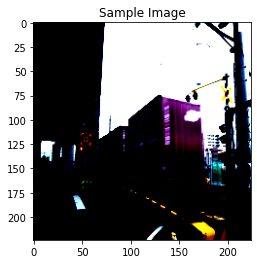

a broken several this a broken through a behind of


In [48]:
get_prediction(test_data_loader)